Code from [scale embedding-decoder](https://git.scc.kit.edu/scale/research/embedding-decoder) with slight changes

In [1]:
import tensorflow as tf
import random
import networkx as nx
import math
import numpy as np

from util.map import Map
from util.generate_points import list_to_dict, gen_square, gen_disc

In [15]:
args = Map(
    batch_size = 64,
    epochs = 100,
    random_seed = None,
    graph_size = 100,
    graph_average_degree = 10,
    layers = 3,
    layer_size = 16
)

Nodes: 100
Edges: 545
Average Degree: 10.9
Largest Component Size: 100


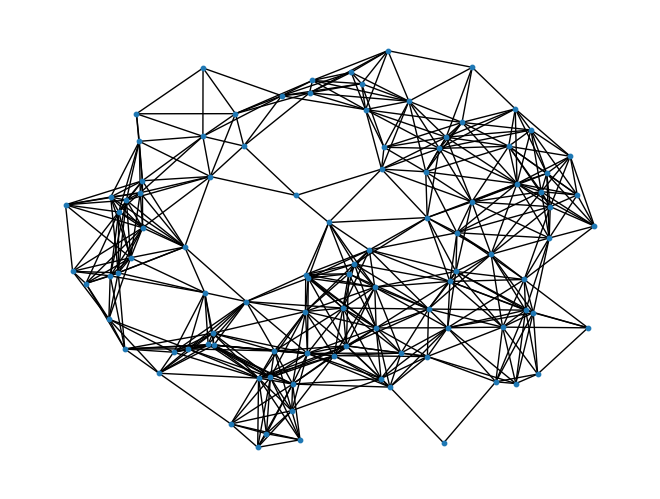

In [16]:
rg_radius = math.sqrt(args.graph_average_degree / (args.graph_size * math.pi))

pos = list_to_dict(gen_disc(args.graph_size))
nx_graph = nx.random_geometric_graph(args.graph_size, rg_radius, pos=pos)  # not based on rng seed yet!
largest_component = max(nx.connected_components(nx_graph), key=len)

print(f'Nodes: {nx_graph.number_of_nodes()}')
print(f'Edges: {nx_graph.number_of_edges()}')
print(f'Average Degree: {2.0 * nx_graph.number_of_edges() / nx_graph.number_of_nodes()}')
print(f'Largest Component Size: {len(largest_component)}')
#pos = nx.circular_layout(nx_graph)
nx.draw(nx_graph, pos, node_size=10)

In [17]:
# tensorflow

# generate dataset from graph. checks and remembers for all pairs of nodes if they were connected by an edge or not.
ds_matracies = []
ds_labels = []
adj = nx.adjacency_matrix(nx_graph)
nodes = nx.nodes(nx_graph)

for x in range(nx_graph.number_of_nodes()):
    for y in range(nx_graph.number_of_nodes()):
        ds_matracies.append(np.append((nodes[x]['pos']), (nodes[y]['pos'])))
                              #append (shape(4)) or vstack (shape(2,2))? probably no difference for an AI
        ds_labels.append(1 if nx_graph.has_edge(x, y) else 0)

full_dataset = tf.data.Dataset.from_tensor_slices((ds_matracies, ds_labels)).batch(args.batch_size)

#print(f'Dataset size: {full_dataset.__len__}')
#print(full_dataset)

# note: here is no split into train/validation/test
# since the idea was for the AI to learn one graph and not for it to generalize,
# we thought it more appropriate to overtrain the Network.
# This has so far not been compared to networks trained on split sets.


#build model(s)
model_array = [
    tf.keras.layers.InputLayer(input_shape=(4))] #possible TODO get inputshape dynamically

for i in range(args.layers):
    model_array.append(tf.keras.layers.Dense(args.layer_size, activation='relu')) #make size depending of graph dimensionality? Or would that against the idea?

model_array.append(tf.keras.layers.Flatten())
model_array.append(tf.keras.layers.Dense(1, activation='sigmoid'))

dense_model = tf.keras.Sequential(model_array)

dense_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(), # TODO try other loss function
    metrics=['accuracy']
)

# train
train_history = dense_model.fit(full_dataset, epochs=args.epochs)

# evaluate
test_loss, test_acc = dense_model.evaluate(full_dataset, verbose=0)
#print('\nTest accuracy:', test_acc)
#print('\nTrain history:', train_history.history)
dense_model.summary()

probability_model = tf.keras.Sequential([dense_model, tf.keras.layers.Softmax()])

C:\Users\Paul\AppData\Local\Temp\ipykernel_2156\3731678692.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx_graph)


Epoch 1/100
157/157 [==============================] - 1s 891us/step - loss: 0.4306 - accuracy: 0.8688
Epoch 2/100
157/157 [==============================] - 0s 921us/step - loss: 0.3336 - accuracy: 0.8910
Epoch 3/100
157/157 [==============================] - 0s 1ms/step - loss: 0.3037 - accuracy: 0.8910
Epoch 4/100
157/157 [==============================] - 0s 865us/step - loss: 0.2367 - accuracy: 0.8910
Epoch 5/100
157/157 [==============================] - 0s 865us/step - loss: 0.1727 - accuracy: 0.9091
Epoch 6/100
157/157 [==============================] - 0s 923us/step - loss: 0.1350 - accuracy: 0.9398
Epoch 7/100
157/157 [==============================] - 0s 1000us/step - loss: 0.1134 - accuracy: 0.9566
Epoch 8/100
157/157 [==============================] - 0s 949us/step - loss: 0.1003 - accuracy: 0.9621
Epoch 9/100
157/157 [==============================] - 0s 956us/step - loss: 0.0919 - accuracy: 0.9672
Epoch 10/100
157/157 [==============================] - 0s 898us/step - lo

313/313 [==============================] - 0s 593us/step


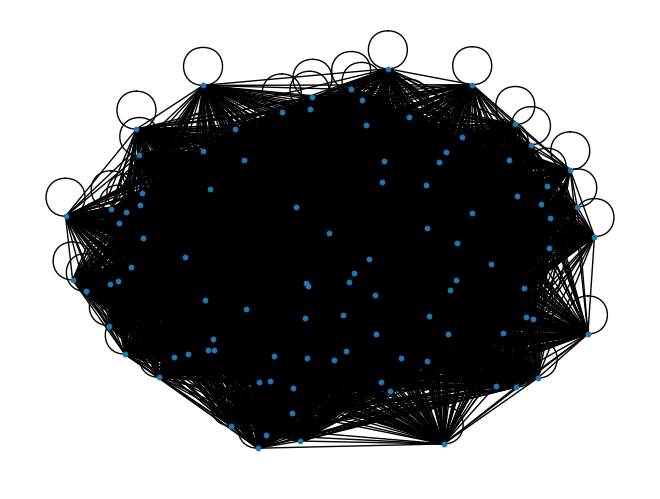

In [18]:
pred_graph = nx.create_empty_copy(nx_graph, with_data=True)

pairs = [ (x, y) for x in range(nx_graph.number_of_nodes()) for y in range(nx_graph.number_of_nodes()) ]
predictions = probability_model.predict([[nodes[pair[0]]['pos'][0], nodes[pair[0]]['pos'][1], nodes[pair[1]]['pos'][0], nodes[pair[1]]['pos'][1]] for pair in pairs ])
#predictions = probability_model.predict([np.append((nodes[pair[0]]['pos']), (nodes[pair[1]]['pos'])) for pair in pairs ])
edges = [ pair for pair, prediction in zip(pairs, predictions) if prediction[0] ]
pred_graph.add_edges_from(edges)

nx.draw(pred_graph, pos, node_size=10)

In [12]:
predictions

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)